0. 准备环境与数据

In [1]:
# import area
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings 
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc,precision_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# read data
OriginalData = pd.read_csv('Data/OriginalData/Wimbledon_featured_matches.csv')

# Q1 The model to captures the flow of play

势头：相对于比赛中平均或预期表现的偏差。
结合这段话“当德约科维奇使用“set_no”列等于1时，你可以看到第一回合的所有分数。令人难以置信的波动，有时是很多分数，甚至是比赛，发生在那些似乎有优势的球员，通常被归因于“势头”
明确定义“势头”在网球比赛中的含义，即：外势、内势→势头→表现
- 对于表现可能的因子为：连续成功或失败次数，短时间内的比赛表现波动：得分速率（优劣）、得分速率标准差（大起大落）；
- 对于外势可能的因子为：发球先后手，；
- 对于内势可能的因子为：心理因素（上一局的表现），当前发球的速度、深度、宽度，获胜的方式，第一位球员上网次数，破发点次数，发出的双误次数等。（结合第一问的相关分析来分析可能的因子）
基于以上指标，我们可以定义一个简单的势头计算模型，将以上各因素加权合并。发球方优势可以通过增加发球方在该时间窗口内赢得的分数/局的权重来体现。

In [3]:
# 提出1701场的数据
match_id = "2023-wimbledon-1701"
match_data = OriginalData[OriginalData['match_id'] == match_id].copy()
match_data.reset_index(drop=True, inplace=True)
match_data.describe()

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,server,serve_no,point_victor,p1_points_won,p2_points_won,game_victor,set_victor,p1_ace,p2_ace,p1_winner,p2_winner,p1_double_fault,p2_double_fault,p1_unf_err,p2_unf_err,p1_net_pt,p2_net_pt,p1_net_pt_won,p2_net_pt_won,p1_break_pt,p2_break_pt,p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,324.000000
mean,3.005988,5.152695,167.500000,0.958084,1.047904,2.236527,1.916168,1.550898,1.365269,1.497006,82.023952,85.476048,0.206587,0.020958,0.026946,0.005988,0.197605,0.095808,0.020958,0.008982,0.134731,0.119760,0.113772,0.170659,0.074850,0.101796,0.056886,0.044910,0.014970,0.014970,0.041916,0.029940,19.780009,18.548407,4.461078,112.882716
std,1.322011,3.175172,96.561725,0.889399,0.562154,1.806158,1.763539,0.498149,0.482228,0.500741,50.143033,46.509365,0.550036,0.180534,0.162169,0.077266,0.398790,0.294770,0.143459,0.094489,0.341948,0.325168,0.318011,0.376775,0.263544,0.302834,0.231973,0.207418,0.121615,0.121615,0.200698,0.170678,17.340056,16.337593,4.093866,11.682532
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.669000,0.492000,0.000000,83.000000
25%,2.000000,3.000000,84.250000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.250000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.899000,7.087250,1.000000,106.750000
50%,3.000000,5.000000,167.500000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,82.500000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.959500,13.033500,3.000000,115.000000
75%,4.000000,7.000000,250.750000,2.000000,1.000000,3.000000,3.000000,2.000000,2.000000,2.000000,127.750000,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.271750,24.954250,6.000000,122.000000
max,5.000000,13.000000,334.000000,2.000000,2.000000,6.000000,6.000000,2.000000,2.000000,2.000000,168.000000,166.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121.060000,93.426000,29.000000,132.000000


因子选取：

表现
- 连续成功或失败次数(在match中，失败为负) (p1_continuous_wl,p2_continuous_wl)
- 全Match得分优势(p1/2_total_advantage)
- 短时间内的比赛表现波动（5分的窗口期）: 
    - 得分优势(p1/2_window_advatage)
    - 赢得的局数和盘数(p1/2_window_sets_won,p1/2_window_games_won)
    - 非受迫性失误p1/2_windows_unforced_errors
    - 破发点p1/2_windows_break_points_won
    - 短时间得分 p1/2_windows_winners

外势
- 发球先后手 p1/2_serve_advantage

内势
- 上一分跑动距离优势p1/2_distance_advantage
- 上一次获胜的方式p1/2_last_shot_type
- 到目前破发点次数p1/2_break_points_won
- 到目前双误次数p1/2_double_faults

In [4]:
# 因子挖掘
def parameter_digging(df, index, window_size=5):
    # 最近连续得分或失分数(失败则为负)
    p1_continuous_wl = 0
    p2_continuous_wl = 0
    for i in range(index, 0, -1):
        if df.loc[i, 'point_victor'] == 1:
            p1_continuous_wl += 1
        else:
            break
    for i in range(index, 0, -1):
        if df.loc[i, 'point_victor'] == 2:
            p2_continuous_wl += 1
        else:
            break
    if p1_continuous_wl == 0:
        p1_continuous_wl = -p2_continuous_wl
    if p2_continuous_wl == 0:
        p2_continuous_wl = -p1_continuous_wl

    # 到目前得分优势(从0到index)
    p1_total_advantage = df['point_victor'].iloc[:index].value_counts().get(1, 0) - df['point_victor'].iloc[:index].value_counts().get(2, 0)
    p2_total_advantage = -p1_total_advantage
    
    # 短时间比赛表现波动（窗口期5）
    # 窗口提取
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 短时间赢得局数和盘数
    p1_window_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_window_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_window_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_window_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]
    
    # 短时间比赛得分优势
    p1_window_advantage = time_window_df['point_victor'].value_counts().get(1, 0) - time_window_df['point_victor'].value_counts().get(2, 0)
    p2_window_advantage = -p1_window_advantage
    
    #短时间破发点
    p1_windows_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_windows_break_points_won = time_window_df['p2_break_pt_won'].sum()
    
    #短时间非受迫性失误
    p1_windows_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_windows_unforced_errors = -time_window_df['p2_unf_err'].sum()
    
    # 短时间得分
    p1_windows_winners = time_window_df['p1_winner'].sum()
    p2_windows_winners = time_window_df['p2_winner'].sum()

    # 先手优势，发球方在每个得分上额外加0.1的权重
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * 0.1
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * 0.1
    
    # 上一把跑动距离差
    if index == 0:
        p1_distance = 0
        p2_distance = 0
    else:
        p1_distance = df['p1_distance_run'].iloc[index-1]
        p2_distance = df['p2_distance_run'].iloc[index-1]
    p1_distance_advantage = p1_distance - p2_distance
    p2_distance_advantage = -p1_distance_advantage
    
    # initialize variables
    p1_last_shot_type = 0
    p2_last_shot_type = 0
    # player1上次得分方法（个人觉得后手更会有助于势头）
    for i in range(index, 0, -1):
        if df['point_victor'].iloc[i] == 1:
            p1_last_shot_type = -1 if df['winner_shot_type'].iloc[i] == 'F' else 1
            break
        else:
            p1_last_shot_type=0
    # player2上次得分方法
    for i in range(index, 0, -1):
        if df['point_victor'].iloc[i] == 2:
            p2_last_shot_type = -1 if df['winner_shot_type'].iloc[i] == 'F' else 1
            break
        else:
            p2_last_shot_type=0
    
    #目前总破发点（从0到index）
    p1_break_points_won = df['p1_break_pt_won'].iloc[:index].sum()
    p2_break_points_won = df['p2_break_pt_won'].iloc[:index].sum()

    #目前总双误次数（负向影响设负数）
    p1_double_faults = -df['p1_double_fault'].iloc[:index].sum()
    p2_double_faults = -df['p2_double_fault'].iloc[:index].sum()

    return [p1_continuous_wl, p2_continuous_wl, p1_total_advantage, p2_total_advantage, p1_window_sets_won, p2_window_sets_won, p1_window_games_won, p2_window_games_won, p1_window_advantage, p2_window_advantage, p1_windows_break_points_won, p2_windows_break_points_won, p1_windows_unforced_errors, p2_windows_unforced_errors, p1_windows_winners, p2_windows_winners, p1_serve_advantage, p2_serve_advantage, p1_distance_advantage, p2_distance_advantage, p1_last_shot_type, p2_last_shot_type, p1_break_points_won, p2_break_points_won, p1_double_faults, p2_double_faults]

In [5]:
def parameter_dataframe(df):
    parameter_list = []
    for i in range(len(df)):
        parameter_list.append(parameter_digging(df, i))
    parameter_df = pd.DataFrame(parameter_list, columns=['p1_continuous_wl', 'p2_continuous_wl', 'p1_total_advantage', 'p2_total_advantage', 'p1_window_sets_won', 'p2_window_sets_won', 'p1_window_games_won', 'p2_window_games_won', 'p1_window_advantage', 'p2_window_advantage', 'p1_windows_break_points_won', 'p2_windows_break_points_won', 'p1_windows_unforced_errors', 'p2_windows_unforced_errors', 'p1_windows_winners', 'p2_windows_winners', 'p1_serve_advantage', 'p2_serve_advantage', 'p1_distance_advantage', 'p2_distance_advantage', 'p1_last_shot_type', 'p2_last_shot_type', 'p1_break_points_won', 'p2_break_points_won', 'p1_double_faults', 'p2_double_faults'])
    return parameter_df

In [6]:
def process_match_data(match_data):
    parameter_df_match = parameter_dataframe(match_data)
    p1_parameter_df = parameter_df_match[['p1_continuous_wl', 'p1_total_advantage', 'p1_window_sets_won', 'p1_window_games_won', 'p1_window_advantage', 'p1_windows_break_points_won', 'p1_windows_unforced_errors', 'p1_windows_winners', 'p1_serve_advantage', 'p1_distance_advantage', 'p1_last_shot_type', 'p1_break_points_won', 'p1_double_faults']]
    p2_parameter_df = parameter_df_match[['p2_continuous_wl', 'p2_total_advantage', 'p2_window_sets_won', 'p2_window_games_won', 'p2_window_advantage', 'p2_windows_break_points_won', 'p2_windows_unforced_errors', 'p2_windows_winners', 'p2_serve_advantage', 'p2_distance_advantage', 'p2_last_shot_type', 'p2_break_points_won', 'p2_double_faults']]
    return p1_parameter_df, p2_parameter_df

p1_parameter_df, p2_parameter_df = process_match_data(match_data)

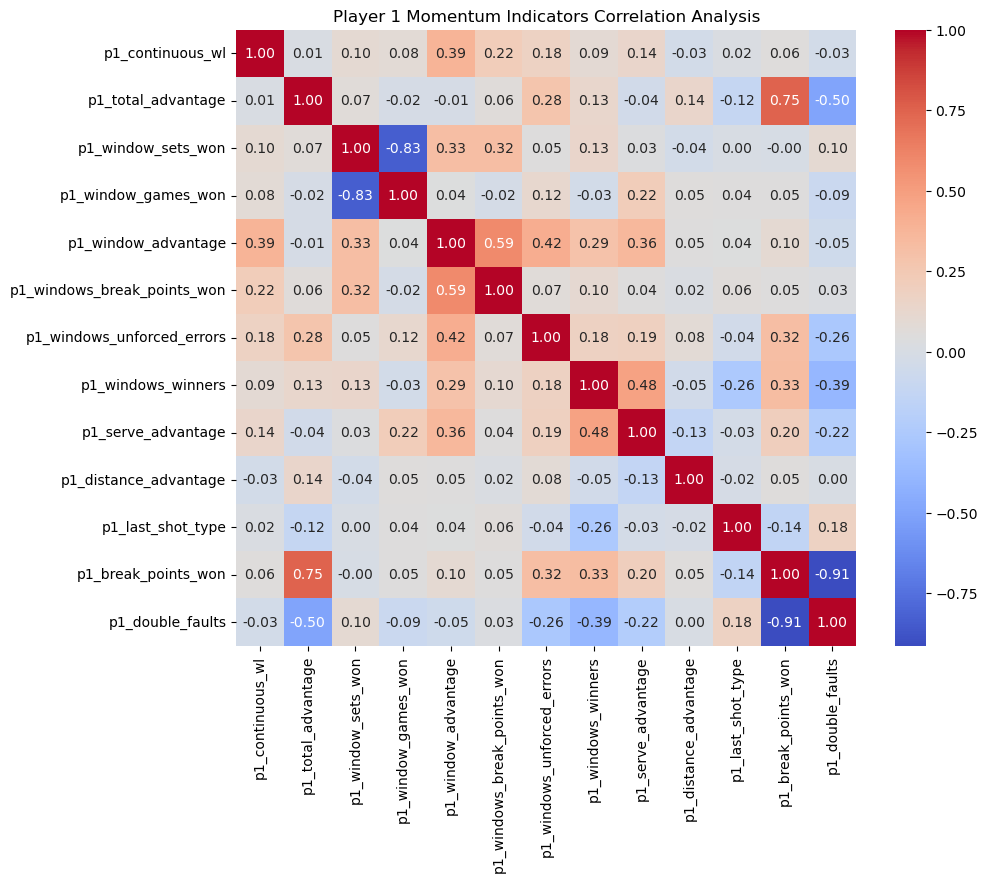

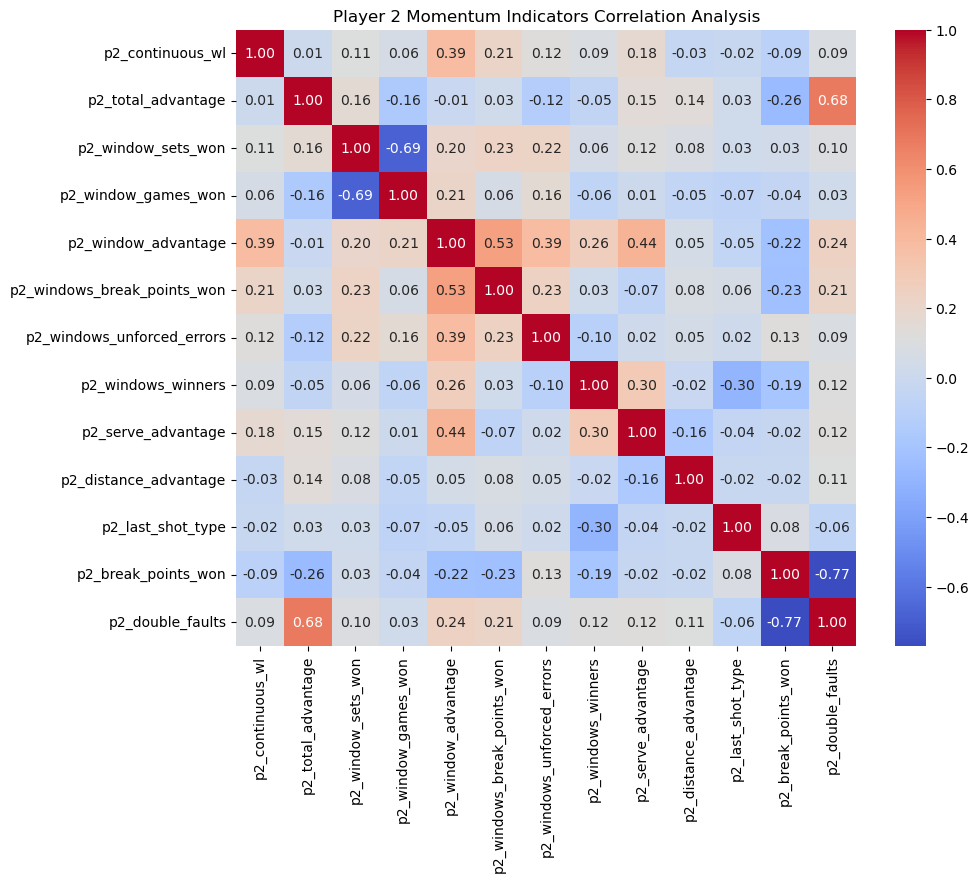

In [7]:
def plot_corr_heatmap(parameter_df, player_name):
    # Calculate correlation matrix
    corr = parameter_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{player_name} Momentum Indicators Correlation Analysis')
    plt.show()

# Plot correlation heatmap for Player 1
plot_corr_heatmap(p1_parameter_df, 'Player 1')

# Plot correlation heatmap for Player 2
plot_corr_heatmap(p2_parameter_df, 'Player 2')


相关系数都很低，排除多重共线性

In [8]:
def entropy_weight_method(data):
    """
    熵权法计算各指标的权重
    :param data: DataFrame, 各指标的数据
    :return: 权重数组
    """
    # 数据标准化处理
    data_normalized = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    # 计算每个指标的熵值
    epsilon = 1e-12  # 避免log(0)
    p_matrix = data_normalized / data_normalized.sum()
    e_matrix = -np.sum(p_matrix * np.log(p_matrix + epsilon), axis=0) / np.log(len(data))
    
    # 计算每个指标的差异系数
    d_matrix = 1 - e_matrix
    
    # 计算权重
    weights = d_matrix / d_matrix.sum()
    
    return weights

# 计算球员1和球员2的指标权重
weights_p1 = entropy_weight_method(p1_parameter_df)
weights_p2 = entropy_weight_method(p2_parameter_df)

# 输出权重
print('Player 1 Momentum Indicators Weights:')
print(weights_p1)
print('\n Player 2 Momentum Indicators Weights:')
print(weights_p2)

# 计算加权后的综合得分
player1_score = (p1_parameter_df * weights_p1).sum(axis=1)
player2_score = (p2_parameter_df * weights_p2).sum(axis=1)

# 将综合得分加入原数据中
p1_parameter_df['Momumtum'] = player1_score
p2_parameter_df['Momumtum'] = player2_score

Player 1 Momentum Indicators Weights:
p1_continuous_wl               0.008318
p1_total_advantage             0.028414
p1_window_sets_won             0.439478
p1_window_games_won            0.007500
p1_window_advantage            0.007695
p1_windows_break_points_won    0.285504
p1_windows_unforced_errors     0.021789
p1_windows_winners             0.039788
p1_serve_advantage             0.027558
p1_distance_advantage          0.003370
p1_last_shot_type              0.035039
p1_break_points_won            0.055510
p1_double_faults               0.040037
dtype: float64

 Player 2 Momentum Indicators Weights:
p2_continuous_wl               0.012228
p2_total_advantage             0.017533
p2_window_sets_won             0.433333
p2_window_games_won            0.010326
p2_window_advantage            0.008012
p2_windows_break_points_won    0.277632
p2_windows_unforced_errors     0.010381
p2_windows_winners             0.070296
p2_serve_advantage             0.014760
p2_distance_advantage      

In [9]:
# 将计算得到的势头值分配回原始数据集
match_data['p1_momentum']=pd.DataFrame(p1_parameter_df['Momumtum'])
match_data['p2_momentum']=pd.DataFrame(p2_parameter_df['Momumtum'])
# 显示更新后的数据集的前几行，包括势头值
# match_data[['match_id', 'player1', 'player2', 'elapsed_time', 'p1_momentum', 'p2_momentum']].head()

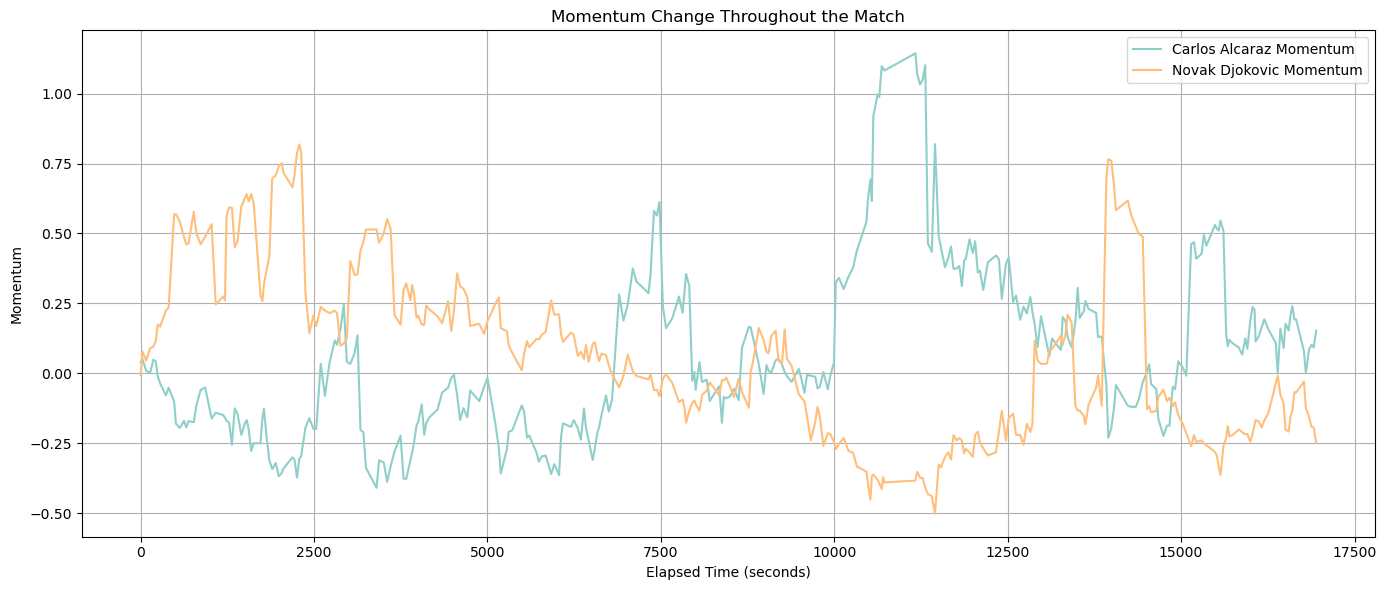

In [10]:
# 将 elapsed_time 转换为可比较的数值（秒）
elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
plt.plot(elapsed_seconds, match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='#8ECFC9')
# 绘制球员2的势头变化
plt.plot(elapsed_seconds, match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='#FFBE7A')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


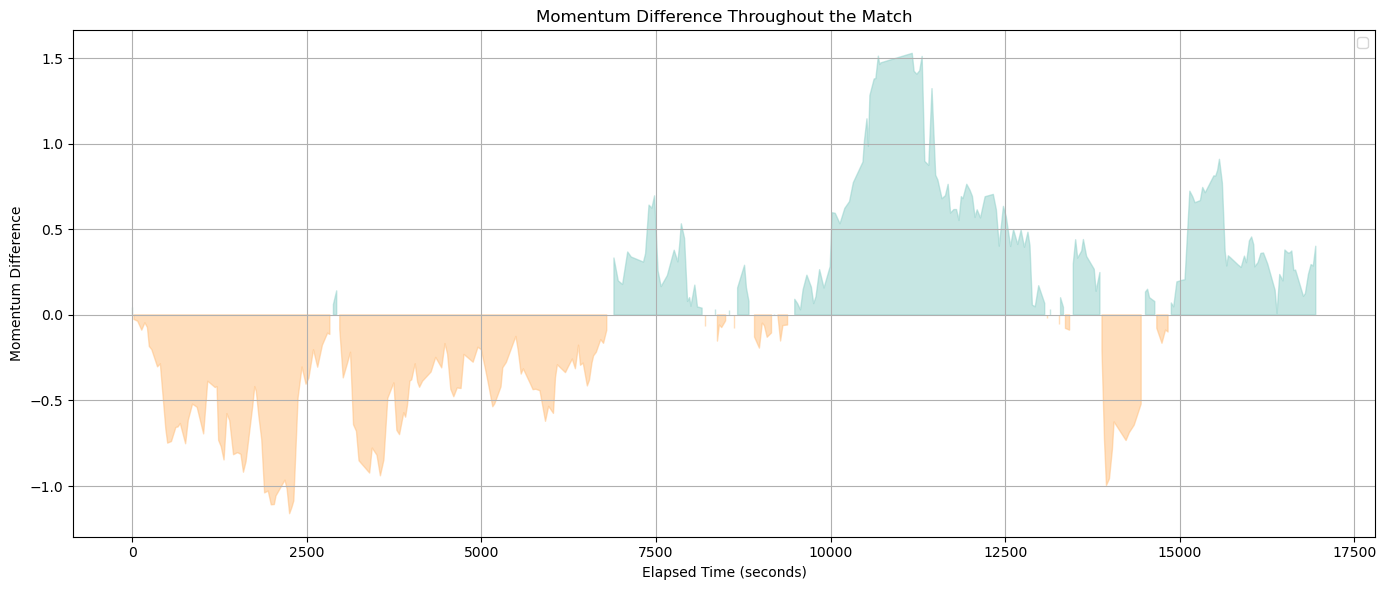

In [11]:
# P1和P2的差距图像
plt.figure(figsize=(14, 6))
momentum_difference = match_data['p1_momentum'] - match_data['p2_momentum']
#plt.plot(elapsed_seconds, momentum_difference, label='Momentum Difference', color='black')
plt.fill_between(elapsed_seconds, momentum_difference, where=momentum_difference > 0, color='#8ECFC9', alpha=0.5)
plt.fill_between(elapsed_seconds, momentum_difference, where=momentum_difference < 0, color='#FFBE7A', alpha=0.5)
plt.legend()
plt.title('Momentum Difference Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

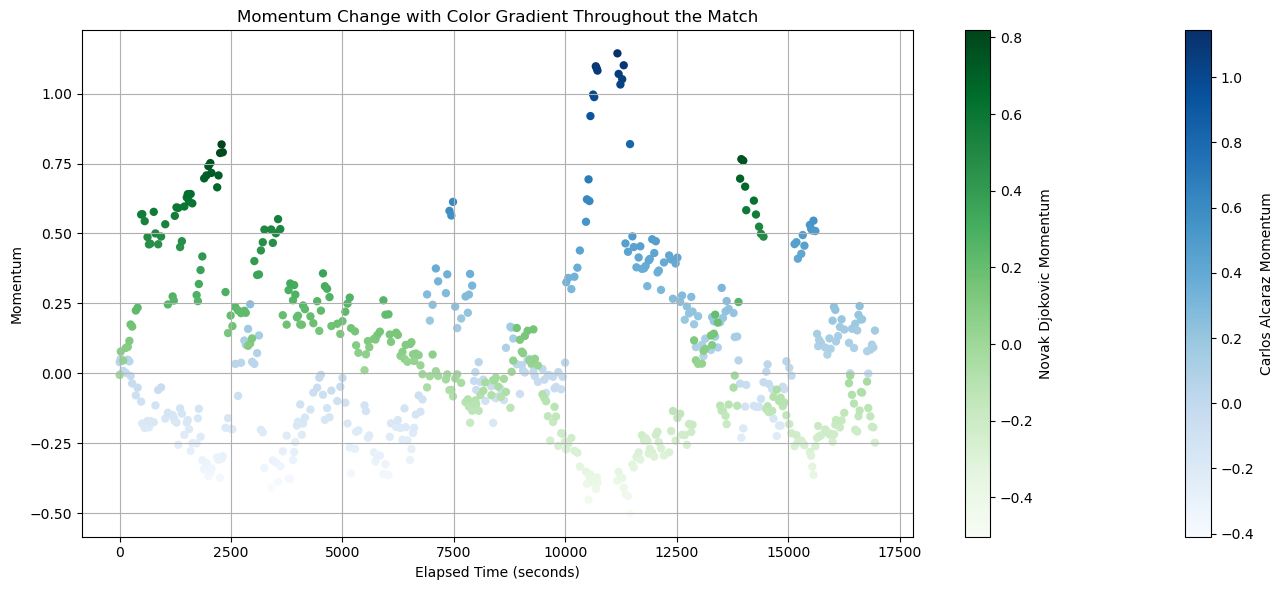

In [12]:
# 为了使用渐变色表示球员在特定时刻的优势程度，我们将使用散点图，其中点的颜色深浅表示势头的大小。

# 创建颜色映射
# 势头值范围
momentum_range = np.linspace(min(min(match_data['p1_momentum']), min(match_data['p2_momentum'])),
                             max(max(match_data['p1_momentum']), max(match_data['p2_momentum'])), num=100)
# 创建一个颜色映射对象
cmap = plt.get_cmap('YlGnBu')

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
sc1 = plt.scatter(elapsed_seconds, match_data['p1_momentum'], c=match_data['p1_momentum'], cmap='Blues', label=match_data['player1'].iloc[0] + " Momentum", edgecolor='none')
# 绘制球员2的势头变化
sc2 = plt.scatter(elapsed_seconds, match_data['p2_momentum'], c=match_data['p2_momentum'], cmap='Greens', label=match_data['player2'].iloc[0] + " Momentum", edgecolor='none')

# 添加颜色条
cbar1 = plt.colorbar(sc1, orientation='vertical')
cbar2 = plt.colorbar(sc2, orientation='vertical')
cbar1.set_label(match_data['player1'].iloc[0] + ' Momentum')
cbar2.set_label(match_data['player2'].iloc[0] + ' Momentum')

# 设置标题和坐标轴标签
plt.title('Momentum Change with Color Gradient Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 显示图表
plt.grid(True)
plt.tight_layout()
plt.show()

# Q2 Assess whether the swings in play and runs of success by one player are random

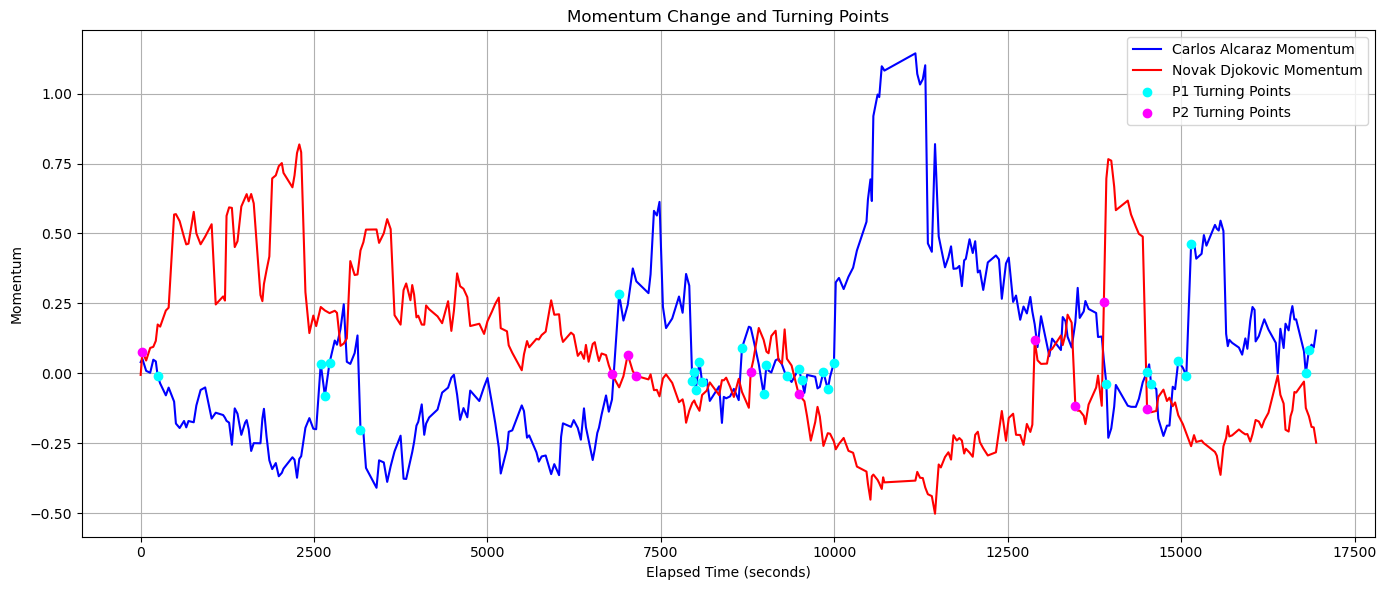

In [13]:
def turning_points_detection(series):
    # 识别转折点：当累积和重新穿过零点时，认为是一个转折点
    turning_points = []
    for i in range(1, len(series)):
        # 如果累积和的符号与前一个不同，则认为是转折点
        if series.iloc[i] * series.iloc[i-1] <= 0:
            turning_points.append(i)
    
    return turning_points

# 应用算法来识别两位球员势头的转折点
p1_turning_points = turning_points_detection(match_data['p1_momentum'])
p2_turning_points = turning_points_detection(match_data['p2_momentum'])

# 绘制势头变化和转折点
plt.figure(figsize=(14, 6))
plt.plot(elapsed_seconds, match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='blue')
plt.plot(elapsed_seconds, match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='red')

# 标记转折点
plt.scatter(elapsed_seconds.iloc[p1_turning_points], match_data['p1_momentum'].iloc[p1_turning_points], color='cyan', label='P1 Turning Points', zorder=5)
plt.scatter(elapsed_seconds.iloc[p2_turning_points], match_data['p2_momentum'].iloc[p2_turning_points], color='magenta', label='P2 Turning Points', zorder=5)

plt.legend()
plt.title('Momentum Change and Turning Points')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def mark_indices_in_list(length, indices):
    """
    根据指定的索引列表，在长度为length的列表中标记索引位置。
    
    :param length: 列表的长度
    :param indices: 需要标记为1的索引值列表
    :return: 标记后的列表，其中指定索引位置为1，其他位置为0
    """
    # 初始化列表，长度为length，所有值为0
    marked_list = [0] * length
    
    # 在指定索引位置标记为1
    for index in indices:
        if index < length:  # 确保索引在列表长度范围内
            marked_list[index] = 1
            
    return marked_list
list_length=len(match_data)
p1_turning_points = mark_indices_in_list(list_length, p1_turning_points)
p2_turning_points = mark_indices_in_list(list_length, p2_turning_points)
match_data['p1_turning_points']=p1_turning_points
match_data['p2_turning_points']=p2_turning_points

In [15]:
def runs_test(sequence):
    """
    游程检验，判断序列随机性。
    :param sequence: 输入的序列 (list or np.array)
    :return: Z统计量和p值
    """
    # 将序列分为两类
    median_value = np.median(sequence)
    binary_sequence = [1 if x > median_value else 0 for x in sequence]
    
    # 计算游程数量
    runs = 1  # 至少有一个游程
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i-1]:
            runs += 1
    # 计算期望的游程数量和标准差
    n1 = binary_sequence.count(1)
    n2 = binary_sequence.count(0)
    expected_runs = 2 * n1 * n2 / (n1 + n2) + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n1 + n2 - 1)
    # 计算Z统计量
    Z = (runs - expected_runs) / np.sqrt(variance)
    # 计算p值
    p_value = 2 * (1 - norm.cdf(abs(Z)))  # 双尾检验
    return Z, p_value

In [16]:
# p值检验函数
def getva(x):
    if x<0.05:
        return 1
    else:
        return 0

In [17]:
# 运行游程检验来判断球员1和球员2的势头和转折点序列是否为随机序列
Z1, p_value1 = runs_test(match_data['p1_momentum'])
Z2, p_value2 = runs_test(match_data['p2_momentum'])
Z3, p_value3 = runs_test(p1_turning_points)
Z4, p_value4 = runs_test(p2_turning_points)

# 打印球员1势头的游程检验结果
print("Player 1 Momentum Runs Test:")
print("Z statistic:", Z1)
print("p-value:", p_value1)

# 打印球员2势头的游程检验结果
print("\nPlayer 2 Momentum Runs Test:")
print("Z statistic:", Z2)
print("p-value:", p_value2)

# 打印球员1转折点的游程检验结果
print("\nPlayer 1 Turning Points Runs Test:")
print("Z statistic:", Z3)
print("p-value:", p_value3)

# 打印球员2转折点的游程检验结果
print("\nPlayer 2 Turning Points Runs Test:")
print("Z statistic:", Z4)
print("p-value:", p_value4)

# 打印解释
print("\nInterpretation:")
print("p-value < 0.05: Reject the null hypothesis (non-random sequence)")
print("p-value > 0.05: Fail to reject the null hypothesis (random sequence)")

Player 1 Momentum Runs Test:
Z statistic: -15.015175211003275
p-value: 0.0

Player 2 Momentum Runs Test:
Z statistic: -17.207171592171637
p-value: 0.0

Player 1 Turning Points Runs Test:
Z statistic: -6.216053422305978
p-value: 5.098146349524768e-10

Player 2 Turning Points Runs Test:
Z statistic: 0.5783201595064497
p-value: 0.5630479863457891

Interpretation:
p-value < 0.05: Reject the null hypothesis (non-random sequence)
p-value > 0.05: Fail to reject the null hypothesis (random sequence)


# Q2 Expansion 应用到所有的比赛中

In [18]:
results = []
for match_id in OriginalData['match_id'].unique():
    match_data = OriginalData[OriginalData['match_id'] == match_id].copy()
    match_data.reset_index(inplace=True,drop=True)
    # 提取参数
    p1_parameter_df, p2_parameter_df = process_match_data(match_data)
    # 计算球员1和球员2的指标权重
    weights_p1 = entropy_weight_method(p1_parameter_df)
    weights_p2 = entropy_weight_method(p2_parameter_df)

    # 计算加权后的综合得分
    player1_score = (p1_parameter_df * weights_p1).sum(axis=1)
    player2_score = (p2_parameter_df * weights_p2).sum(axis=1)

    # 将综合得分加入原数据中
    p1_parameter_df['Momumtum'] = player1_score
    p2_parameter_df['Momumtum'] = player2_score

    # 将计算得到的势头值分配回原始数据集
    match_data['p1_momentum']=pd.DataFrame(p1_parameter_df['Momumtum'])
    match_data['p2_momentum']=pd.DataFrame(p2_parameter_df['Momumtum'])
    # 应用算法来识别两位球员势头的转折点
    p1_turning_points = turning_points_detection(match_data['p1_momentum'])
    p2_turning_points = turning_points_detection(match_data['p2_momentum'])
    list_length=len(match_data)
    p1_turning_points = mark_indices_in_list(list_length, p1_turning_points)
    p2_turning_points = mark_indices_in_list(list_length, p2_turning_points)
    match_data['p1_turning_points']=p1_turning_points
    match_data['p2_turning_points']=p2_turning_points

    Z_statistic, p_value1 = runs_test(player1_score)
    Z_statistic, p_value2 = runs_test(player2_score)
    Z_statistic, p_value3 = runs_test(p1_turning_points)
    Z_statistic, p_value4 = runs_test(p2_turning_points)
    results.append([match_id,getva(p_value1),getva(p_value2),getva(p_value3),getva(p_value4)])

In [19]:
result_pd=pd.DataFrame(results,columns=['match_id','p1_momentumisnotRand','p2_momentumisnotRand','p1_turning_pointsisnotRand','p2_turning_pointsisnotRand'])
result_pd.to_csv('Data/ProcessedData/MomentumRandomRunsTestResults.csv',index=False)

In [20]:
result_pd.describe()

,p1_momentumisnotRand,p2_momentumisnotRand,p1_turning_pointsisnotRand,p2_turning_pointsisnotRand
count,31.0,31.0,31.000000,31.000000
mean,1.0,1.0,0.709677,0.806452
std,0.0,0.0,0.461414,0.401610
min,1.0,1.0,0.000000,0.000000
25%,1.0,1.0,0.000000,1.000000
50%,1.0,1.0,1.000000,1.000000
75%,1.0,1.0,1.000000,1.000000
max,1.0,1.0,1.000000,1.000000


Momentum is not rand
And 70.97%'s Player 1's swings in the play is not rand
And 80.64%'s Player 2's swings in the play is not rand
但是我觉得是不是应该考虑因为每局的选手都不一样，是不是可以把比赛变动的比率全部加起来，也就是
(0.709677+0.806452)/2 = 0.7580645

# Q3 Swings Predict model. Factors ranking 这部分可以不看，建议直接Q3addition

In [21]:
match_id = "2023-wimbledon-1301"
match_data = OriginalData[OriginalData['match_id'] == match_id].copy()
match_data.reset_index(drop=True, inplace=True)
match_data.isnull().sum()

match_id               0
player1                0
player2                0
elapsed_time           0
set_no                 0
game_no                0
point_no               0
p1_sets                0
p2_sets                0
p1_games               0
p2_games               0
p1_score               0
p2_score               0
server                 0
serve_no               0
point_victor           0
p1_points_won          0
p2_points_won          0
game_victor            0
set_victor             0
p1_ace                 0
p2_ace                 0
p1_winner              0
p2_winner              0
winner_shot_type       0
p1_double_fault        0
p2_double_fault        0
p1_unf_err             0
p2_unf_err             0
p1_net_pt              0
p2_net_pt              0
p1_net_pt_won          0
p2_net_pt_won          0
p1_break_pt            0
p2_break_pt            0
p1_break_pt_won        0
p2_break_pt_won        0
p1_break_pt_missed     0
p2_break_pt_missed     0
p1_distance_run        0


In [22]:
# 删除return_depth列
match_data.drop('return_depth', axis=1, inplace=True)
# 用后值填充缺失值
match_data.fillna(method='bfill', inplace=True)

In [23]:
# 提取参数
p1_parameter_df, p2_parameter_df = process_match_data(match_data)
# 计算球员1和球员2的指标权重
weights_p1 = entropy_weight_method(p1_parameter_df)
weights_p2 = entropy_weight_method(p2_parameter_df)
# 计算加权后的综合得分
player1_score = (p1_parameter_df * weights_p1).sum(axis=1)
player2_score = (p2_parameter_df * weights_p2).sum(axis=1)
# 将综合得分加入原数据中
p1_parameter_df['Momumtum'] = player1_score
p2_parameter_df['Momumtum'] = player2_score
# 将计算得到的势头值分配回原始数据集
match_data['p1_momentum'] = pd.DataFrame(p1_parameter_df['Momumtum'])
match_data['p2_momentum'] = pd.DataFrame(p2_parameter_df['Momumtum'])

In [24]:
# 转换elapsed_time为数值类型
match_data['elapsed_time'] = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 对p1_score, p2_score, winner_shot_type, serve_width, serve_depth进行独热编码
match_data = pd.get_dummies(match_data, columns=['p1_score', 'p2_score', 'winner_shot_type', 'serve_width', 'serve_depth'], drop_first=True)

# 对p1_momentum和p2_momentum进行差分并删除第一行空白数据
match_data['p1_momentum_diff'] = match_data['p1_momentum'].diff()
match_data['p2_momentum_diff'] = match_data['p2_momentum'].diff()
match_data.dropna(inplace=True)

In [25]:
match_data.reset_index(drop=True, inplace=True)

In [26]:
# Remove elements from the list using list comprehension
columns_to_remove = ['match_id', 'player1', 'player2', 'elapsed_time','p1_momentum', 'p2_momentum','p1_momentum_diff', 'p2_momentum_diff']  # Specify the columns to remove
updated_columns = [column for column in match_data.columns if column not in columns_to_remove]

In [27]:
# 分离X和Y
X = match_data[updated_columns]
Y1 = match_data['p1_momentum_diff']
Y2 = match_data['p2_momentum_diff']

In [28]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

In [29]:
# 分割测试集与训练集
tr_x1,te_x1,tr_y1,te_y1=train_test_split(X ,Y1,test_size=0.3,random_state=5)
tr_x2,te_x2,tr_y2,te_y2=train_test_split(X ,Y2,test_size=0.3,random_state=5)

Player 1 xgboost回归:
训练集平均绝对百分比误差:0.000
平均绝对误差: 0.011041217675340623
r2_score 0.9756750647590274


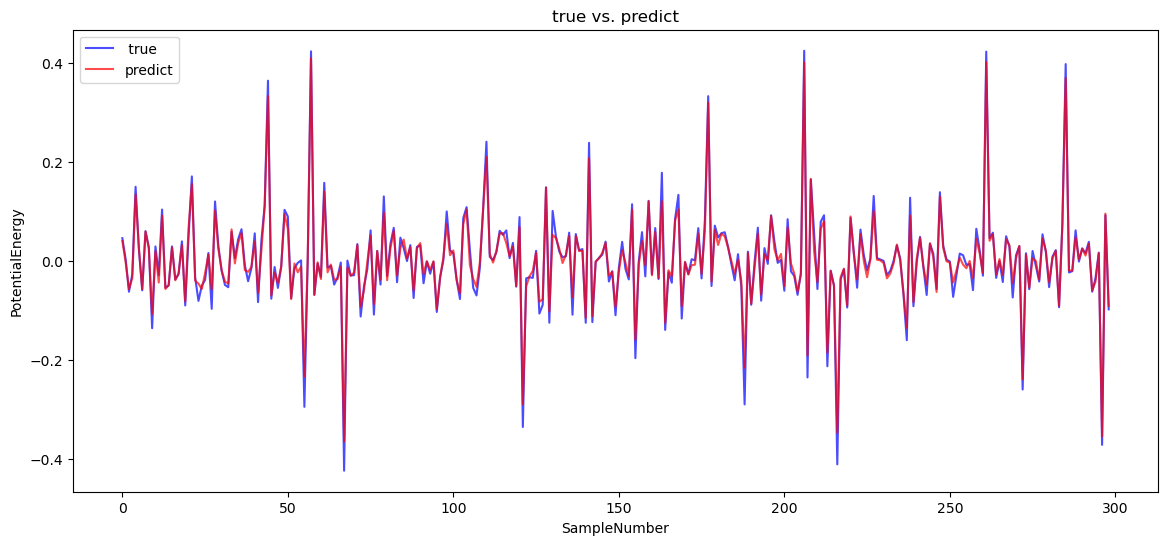

In [30]:
print("Player 1 xgboost回归:")
# 构建xgboost回归模型
xgb_model1 = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model1.fit(X,Y1)
y1_pred = xgb_model1.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model1.predict(X),y1_pred)))
print("平均绝对误差:",mean_absolute_error(Y1, y1_pred))
print("r2_score",r2_score(Y1,y1_pred))
plt.figure(figsize=(14, 6))
plt.plot(list(range(X.shape[0])), Y1, color='blue', label=' true', alpha=0.7)
plt.plot(list(range(X.shape[0])), y1_pred, color='red', label='predict', alpha=0.7)
# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

Player 2 xgboost回归:
训练集平均绝对百分比误差:0.000
平均绝对误差: 0.008127016923553025
r2_score 0.9799722184777631


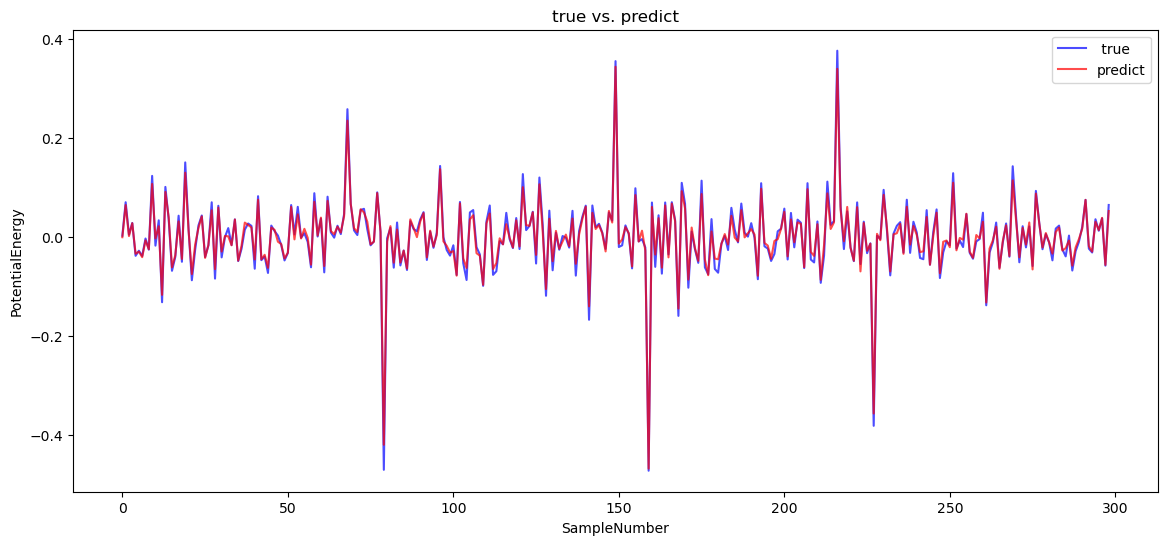

In [31]:
print("Player 2 xgboost回归:")
# 构建xgboost回归模型
xgb_model2 = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model2.fit(X,Y2)
y2_pred = xgb_model2.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model2.predict(X),y2_pred)))
print("平均绝对误差:",mean_absolute_error(Y2, y2_pred))
print("r2_score",r2_score(Y2,y2_pred))
plt.figure(figsize=(14, 6))
plt.plot(list(range(X.shape[0])), Y2, color='blue', label=' true', alpha=0.7)
plt.plot(list(range(X.shape[0])), y2_pred, color='red', label='predict', alpha=0.7)
# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

可以看出XGBOOST可以极好拟合出所有给的数据中势能的diff和因子的模型
下面通过计算SHAP值来进行分析哪些因素最为重要

In [32]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 下以Player 1为例
# 初始化SHAP模型
explainer = shap.Explainer(xgb_model1)
Y=Y1

# 计算SHAP值
shap_values = explainer(X)

In [33]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)

In [34]:
# 将新独热变量还原成原来的变量
shaps = pd.DataFrame(features, columns=['features'])
shaps['shap_values'] = abs_mean_shap_values
classify_table = pd.read_csv('Data\OriginalData\classify_table.csv')
print(shaps)

              features  shap_values
0               set_no     0.002268
1              game_no     0.006019
2             point_no     0.009576
3              p1_sets     0.000000
4              p2_sets     0.000000
5             p1_games     0.004778
6             p2_games     0.003317
7               server     0.002731
8             serve_no     0.000670
9         point_victor     0.006024
10       p1_points_won     0.000000
11       p2_points_won     0.000892
12         game_victor     0.002405
13          set_victor     0.000079
14              p1_ace     0.000000
15              p2_ace     0.001563
16           p1_winner     0.001639
17           p2_winner     0.000426
18     p1_double_fault     0.000128
19     p2_double_fault     0.000175
20          p1_unf_err     0.000503
21          p2_unf_err     0.002249
22           p1_net_pt     0.000032
23           p2_net_pt     0.000760
24       p1_net_pt_won     0.000240
25       p2_net_pt_won     0.000763
26         p1_break_pt     0

In [35]:
# 将Classify_table中的classify列的内容通过features列和shaps表中的features列进行匹配，将shaps表中的features列替换为classify_table中的classify列进行对应并且贴在后面
shaps['features'] = shaps['features'].replace(classify_table.set_index('features')['classify'])
print(shaps)

              features  shap_values
0               set_no     0.002268
1              game_no     0.006019
2             point_no     0.009576
3              p1_sets     0.000000
4              p2_sets     0.000000
5             p1_games     0.004778
6             p2_games     0.003317
7               server     0.002731
8             serve_no     0.000670
9         point_victor     0.006024
10       p1_points_won     0.000000
11       p2_points_won     0.000892
12         game_victor     0.002405
13          set_victor     0.000079
14              p1_ace     0.000000
15              p2_ace     0.001563
16           p1_winner     0.001639
17           p2_winner     0.000426
18     p1_double_fault     0.000128
19     p2_double_fault     0.000175
20          p1_unf_err     0.000503
21          p2_unf_err     0.002249
22           p1_net_pt     0.000032
23           p2_net_pt     0.000760
24       p1_net_pt_won     0.000240
25       p2_net_pt_won     0.000763
26         p1_break_pt     0

In [36]:
shaps = shaps.groupby('features').sum().reset_index()
shaps = shaps.sort_values(by='shap_values', ascending=True)
shaps = shaps.set_index('features')

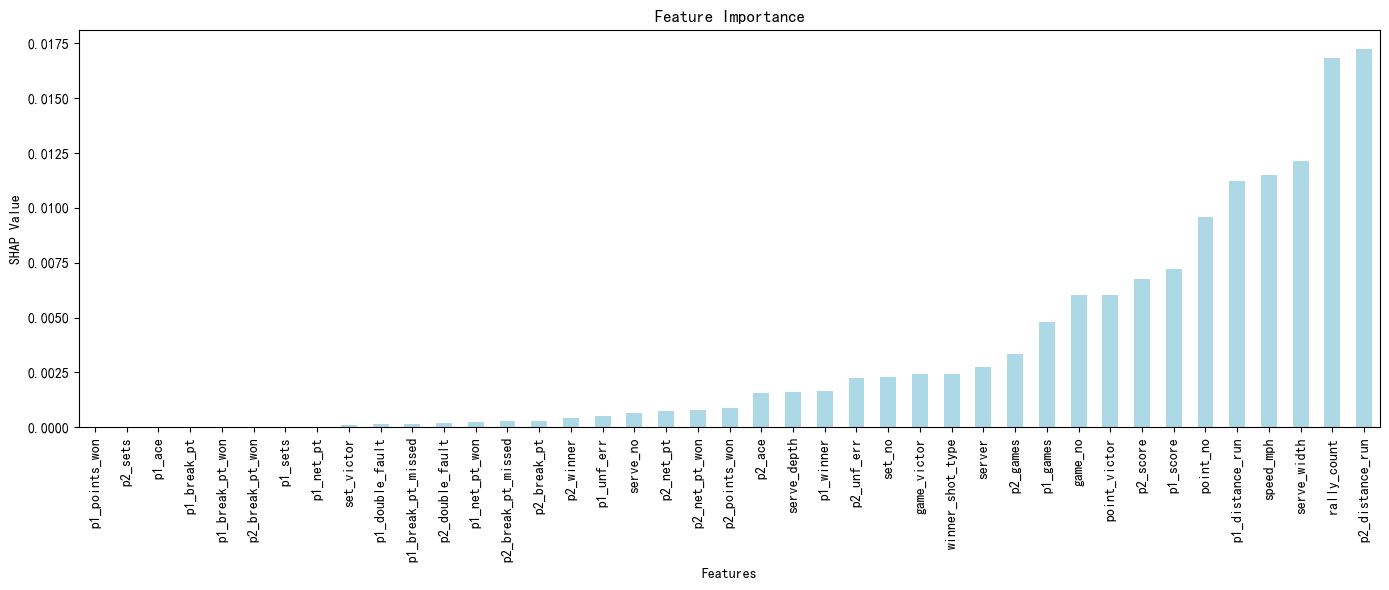

In [37]:
# 绘制shap值的占比方块图
plt.figure(figsize=(14, 6))
shaps['shap_values'].plot(kind='bar', color='lightblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

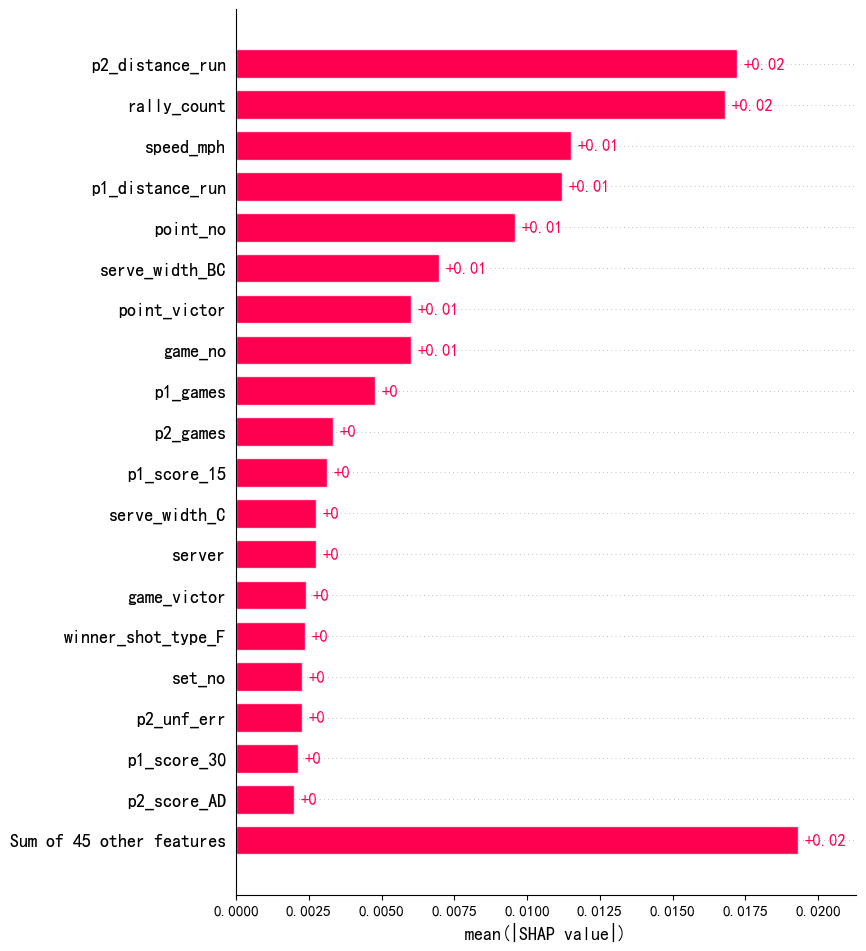

In [38]:
shap.plots.bar(explainer(X),max_display=20)

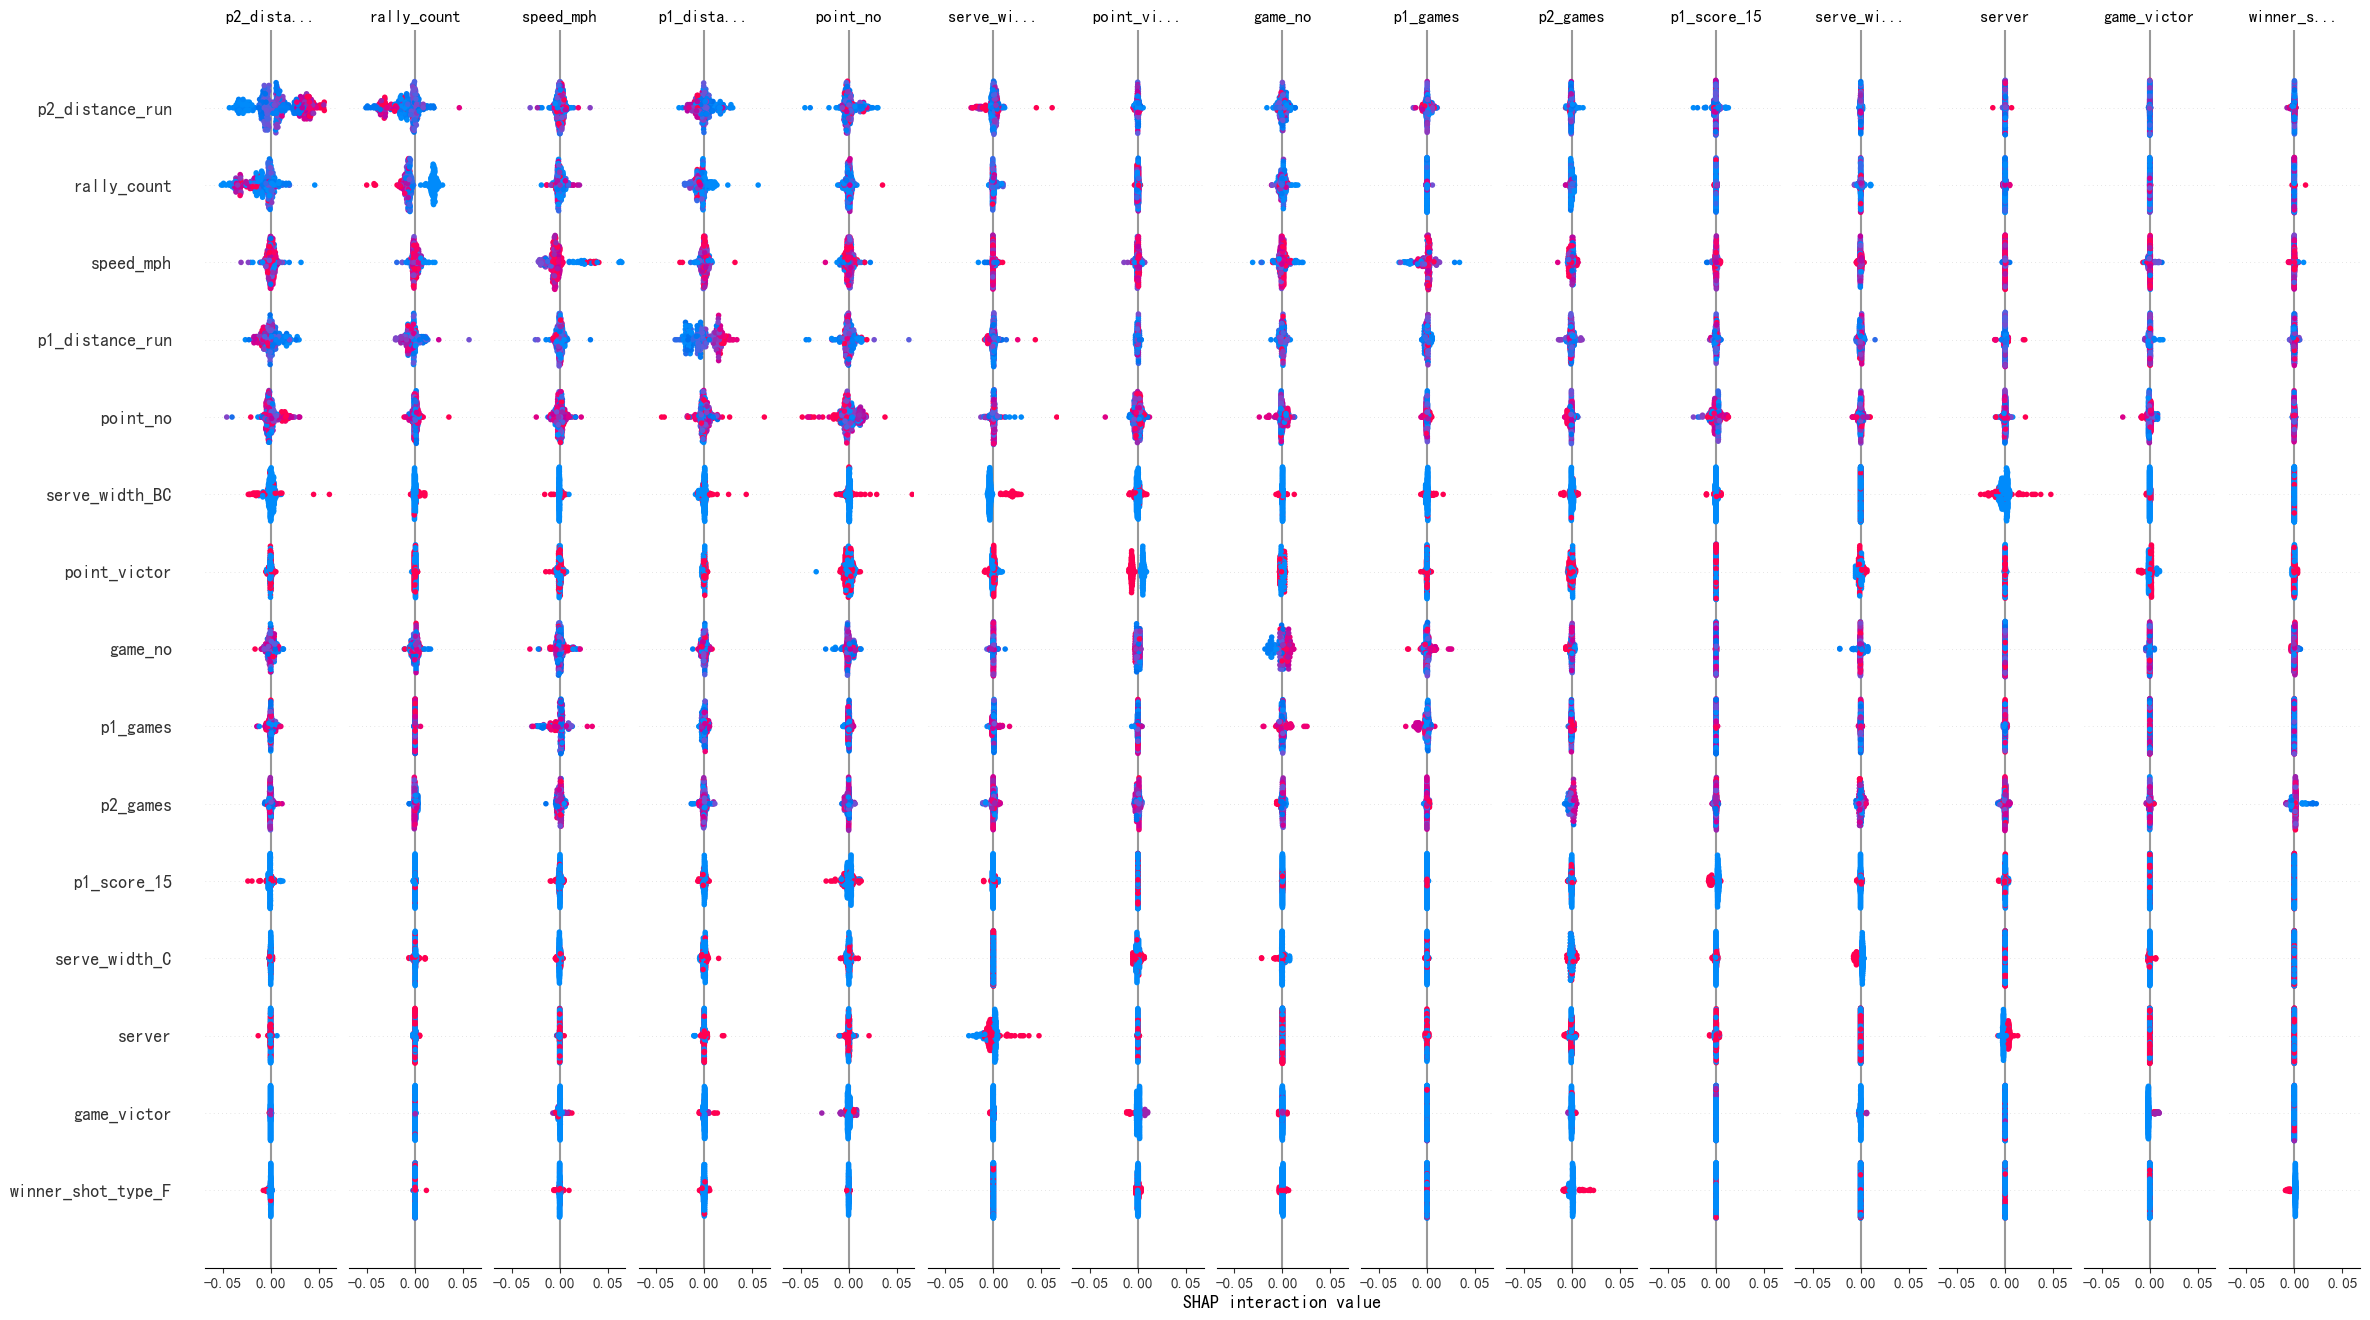

In [39]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=15)

# Q3 ADDITION 将所有的比赛都一起放进运算

In [40]:
processed_data = pd.DataFrame()
for match_id in OriginalData['match_id'].unique():
    match_data = OriginalData[OriginalData['match_id'] == match_id].copy()
    match_data.reset_index(drop=True, inplace=True)
    
    match_data.drop('return_depth', axis=1, inplace=True)
    match_data.fillna(method='bfill', inplace=True)
    
    p1_parameter_df, p2_parameter_df = process_match_data(match_data)
    weights_p1 = entropy_weight_method(p1_parameter_df)
    weights_p2 = entropy_weight_method(p2_parameter_df)
    
    player1_score = (p1_parameter_df * weights_p1).sum(axis=1)
    player2_score = (p2_parameter_df * weights_p2).sum(axis=1)
    
    p1_parameter_df['Momumtum'] = player1_score
    p2_parameter_df['Momumtum'] = player2_score
    
    match_data['p1_momentum'] = pd.DataFrame(p1_parameter_df['Momumtum'])
    match_data['p2_momentum'] = pd.DataFrame(p2_parameter_df['Momumtum'])
    
    match_data['elapsed_time'] = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))
    
    match_data.reset_index(drop=True, inplace=True)
    #print(match_data.columns)
    #print('\n')
    processed_data=pd.concat([processed_data,match_data])
data = processed_data.copy()

In [41]:
# 把p1_score, p2_score中的值替换后再进行独热编码
# 0->0, 15->1, 30->2, 40->3, AD->4
data['p1_score'] = data['p1_score'].replace({'15': 1, '30': 2, '40': 3, 'AD': 4})
data['p2_score'] = data['p2_score'].replace({'15': 1, '30': 2, '40': 3, 'AD': 4})
data['p1_score'] = data['p1_score'].astype(int)
data['p2_score'] = data['p2_score'].astype(int)

In [42]:
data = pd.get_dummies(data, columns=['p1_score', 'p2_score', 'winner_shot_type', 'serve_width', 'serve_depth'], drop_first=True)

In [43]:
# 计算p1_momentum-p2_momentum的值符号改变的点
data['momentum_difference'] = data['p1_momentum'] - data['p2_momentum']

In [44]:
# 应用算法来识别两位球员势头的转折点
momentum_difference_turning_points = turning_points_detection(data['momentum_difference'])
# 将转折点对应的data的条目单独提取出来组成新的dataframe,名叫tp
tp = data.iloc[momentum_difference_turning_points]
tp.reset_index(drop=True, inplace=True)

In [60]:
# 删除全0变量
tp = tp.loc[:, (tp != 0).any(axis=0)]
# 缺失值
#tp.isnull().sum()
# speed_mph用均值补全
tp['speed_mph'].fillna(tp['speed_mph'].mean(), inplace=True)
# p2_distance_run,p1_distance_run,p1_momentum,p2_momentum,momentum_difference,speed_mph,的float64转换为float32
tp['p2_distance_run'] = tp['p2_distance_run'].astype('float32')
tp['p1_distance_run'] = tp['p1_distance_run'].astype('float32')
tp['p1_momentum'] = tp['p1_momentum'].astype('float32')
tp['p2_momentum'] = tp['p2_momentum'].astype('float32')
tp['momentum_difference'] = tp['momentum_difference'].astype('float32')
tp['speed_mph'] = tp['speed_mph'].astype('float32')

tp.dtypes

match_id                object
player1                 object
player2                 object
elapsed_time             int64
set_no                   int64
game_no                  int64
point_no                 int64
p1_sets                  int64
p2_sets                  int64
p1_games                 int64
p2_games                 int64
server                   int64
serve_no                 int64
point_victor             int64
p1_points_won            int64
p2_points_won            int64
game_victor              int64
set_victor               int64
p1_ace                   int64
p2_ace                   int64
p1_winner                int64
p2_winner                int64
p1_double_fault          int64
p2_double_fault          int64
p1_unf_err               int64
p2_unf_err               int64
p1_net_pt                int64
p2_net_pt                int64
p1_net_pt_won            int64
p2_net_pt_won            int64
p1_break_pt              int64
p2_break_pt              int64
p1_break

In [61]:
tp.columns

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server',
       'serve_no', 'point_victor', 'p1_points_won', 'p2_points_won',
       'game_victor', 'set_victor', 'p1_ace', 'p2_ace', 'p1_winner',
       'p2_winner', 'p1_double_fault', 'p2_double_fault', 'p1_unf_err',
       'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'p1_momentum', 'p2_momentum', 'p1_score_1', 'p1_score_2', 'p1_score_3',
       'p1_score_4', 'p1_score_5', 'p1_score_6', 'p2_score_1', 'p2_score_2',
       'p2_score_3', 'p2_score_4', 'p2_score_5', 'p2_score_7',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_BC',
       'serve_width_BW', 'serve_width_C', 'serve_width_W', 'serve_dep

In [62]:
X = tp[['set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server',
       'serve_no', 'point_victor', 'p1_points_won', 'p2_points_won',
       'game_victor', 'set_victor', 'p1_ace', 'p2_ace', 'p1_winner',
       'p2_winner', 'p1_double_fault', 'p2_double_fault', 'p1_unf_err',
       'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'p1_score_1', 'p1_score_2', 'p1_score_3',
       'p1_score_4', 'p1_score_5', 'p1_score_6', 'p2_score_1', 'p2_score_2',
       'p2_score_3', 'p2_score_4', 'p2_score_5', 'p2_score_7',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_BC',
       'serve_width_BW', 'serve_width_C', 'serve_width_W', 'serve_depth_NCTL']]
Y = tp['momentum_difference']

神经网络:
训练集平均绝对百分比误差:2.565
测试集平均绝对百分比误差:2.375
平均绝对误差: 0.184030204115763
r2_score -5.37477450342711

决策树回归:
训练集平均绝对百分比误差:0.000
测试集平均绝对百分比误差:9.568
平均绝对误差: 0.11495947545649364
r2_score -1.3718853989712594

随机森林回归:
训练集平均绝对百分比误差:2.646
测试集平均绝对百分比误差:5.635
平均绝对误差: 0.07343198493783548
r2_score -0.0726195713218416

Adaboost回归:
训练集平均绝对百分比误差:6.105
测试集平均绝对百分比误差:6.729
平均绝对误差: 0.08093237188482293
r2_score -0.15062531452364958

GBDT回归:
训练集平均绝对百分比误差:5.012
测试集平均绝对百分比误差:2.197
平均绝对误差: 0.046733095728809904
r2_score 0.651901600564173

xgboost回归:
训练集平均绝对百分比误差:0.084
测试集平均绝对百分比误差:0.114
平均绝对误差: 0.0010419203
r2_score 0.9997777038058387


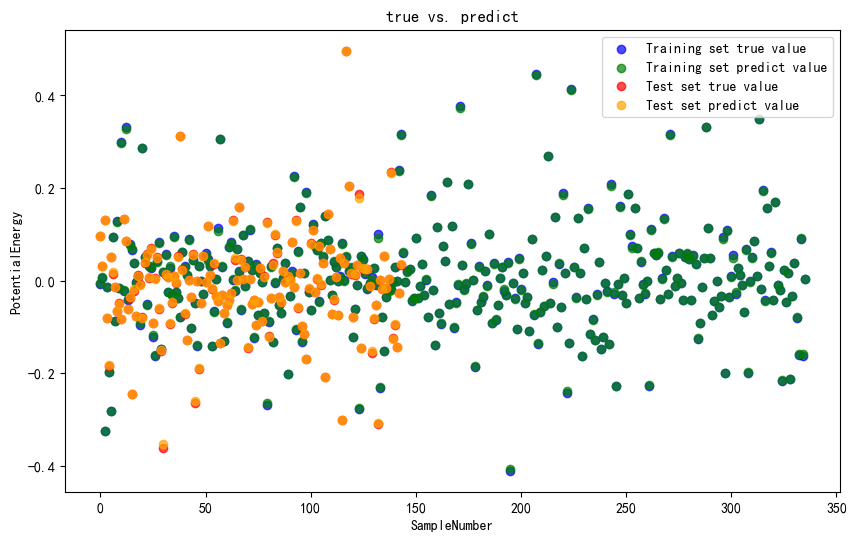

In [64]:
# 为什么选XGBoost模型？
# 划分训练集和测试集进行模型评估
tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.3,random_state=5)

model=MLPRegressor(hidden_layer_sizes=10,max_iter=1000).fit(tr_x,tr_y)
y_pred=model.predict(te_x)

print("神经网络:")
print("训练集平均绝对百分比误差:{:.3f}".format(mape(model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

print("\n决策树回归:")
tree=DecisionTreeRegressor(max_depth=50,random_state=0)
tree.fit(tr_x,tr_y)
y_pred = tree.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

print("\n随机森林回归:")
rf=RandomForestRegressor()
rf.fit(tr_x,tr_y)
y_pred = rf.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

print("\nAdaboost回归:")
# 构建Adaboost回归模型
ada_model = AdaBoostRegressor(n_estimators=100)
ada_model.fit(tr_x,tr_y)
y_pred = ada_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

print("\nGBDT回归:")
# 构建GBDT回归模型
gbdt_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X, Y)
y_pred = gbdt_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, Y)

y_pred = xgb_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = xgb_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

发现xgboost结果最好

In [65]:
# XGboost回归
# tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.3,random_state=5)
xgb_model = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model.fit(X,Y)
y_pred = xgb_model.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(X),y_pred)))
print("平均绝对误差:",mean_absolute_error(Y, y_pred))
print("r2_score",r2_score(Y,y_pred))

训练集平均绝对百分比误差:0.000
平均绝对误差: 0.015258861
r2_score 0.9636688344258433


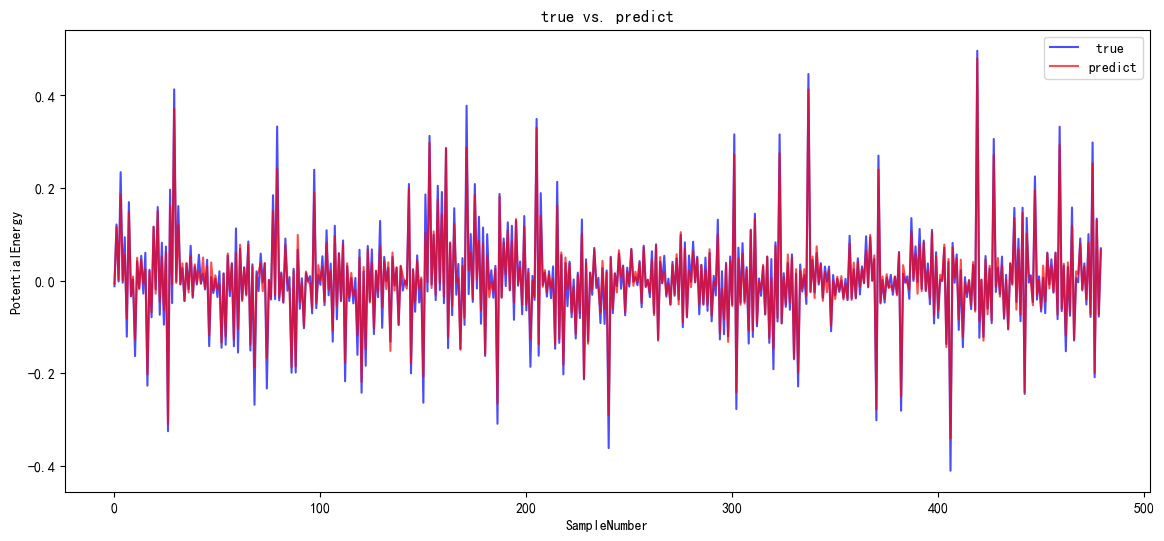

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(list(range(X.shape[0])), Y, color='blue', label=' true', alpha=0.7)
plt.plot(list(range(X.shape[0])), y_pred, color='red', label='predict', alpha=0.7)
# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

In [67]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)

# 计算SHAP值
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)

In [68]:
# 将新独热变量还原成原来的变量
shaps = pd.DataFrame(features, columns=['features'])
shaps['shap_values'] = abs_mean_shap_values
classify_table = pd.read_csv('Data\OriginalData\classify_table.csv')

In [69]:
# 将Classify_table中的classify列的内容通过features列和shaps表中的features列进行匹配，将shaps表中的features列替换为classify_table中的classify列进行对应并且贴在后面
shaps['features'] = shaps['features'].replace(classify_table.set_index('features')['classify'])
shaps = shaps.groupby('features').sum().reset_index()
shaps = shaps.sort_values(by='shap_values', ascending=True)
shaps = shaps.set_index('features')

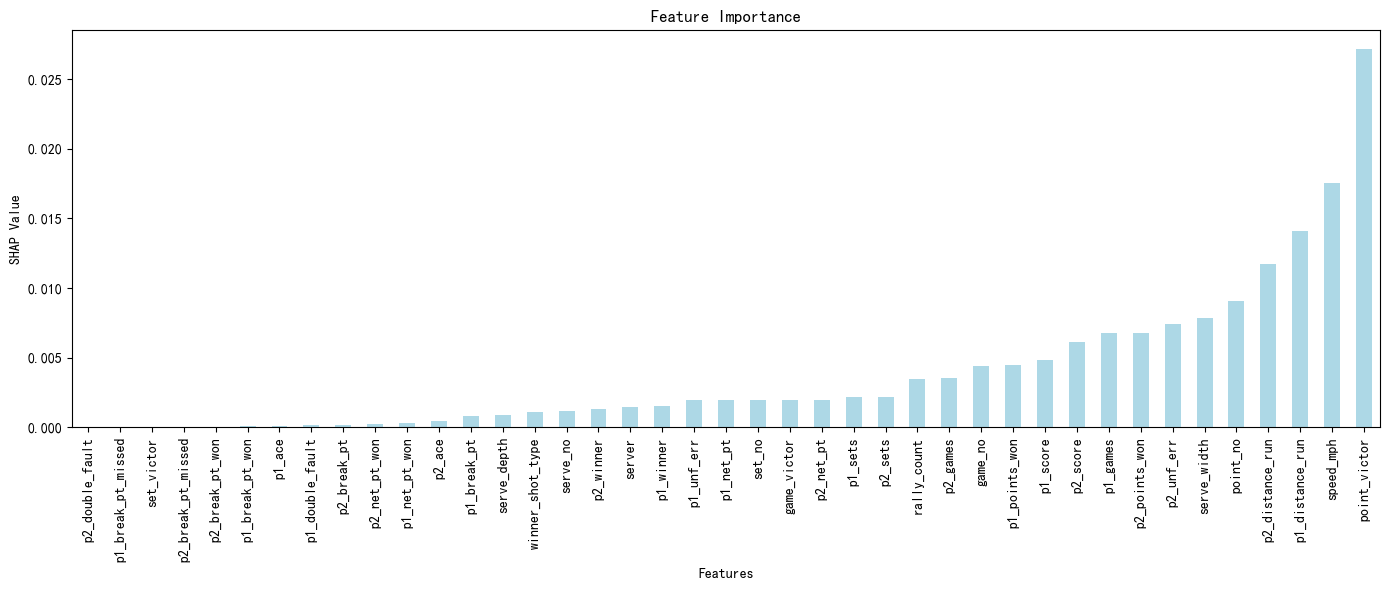

In [70]:
# 绘制shap值的占比方块图
plt.figure(figsize=(14, 6))
shaps['shap_values'].plot(kind='bar', color='lightblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

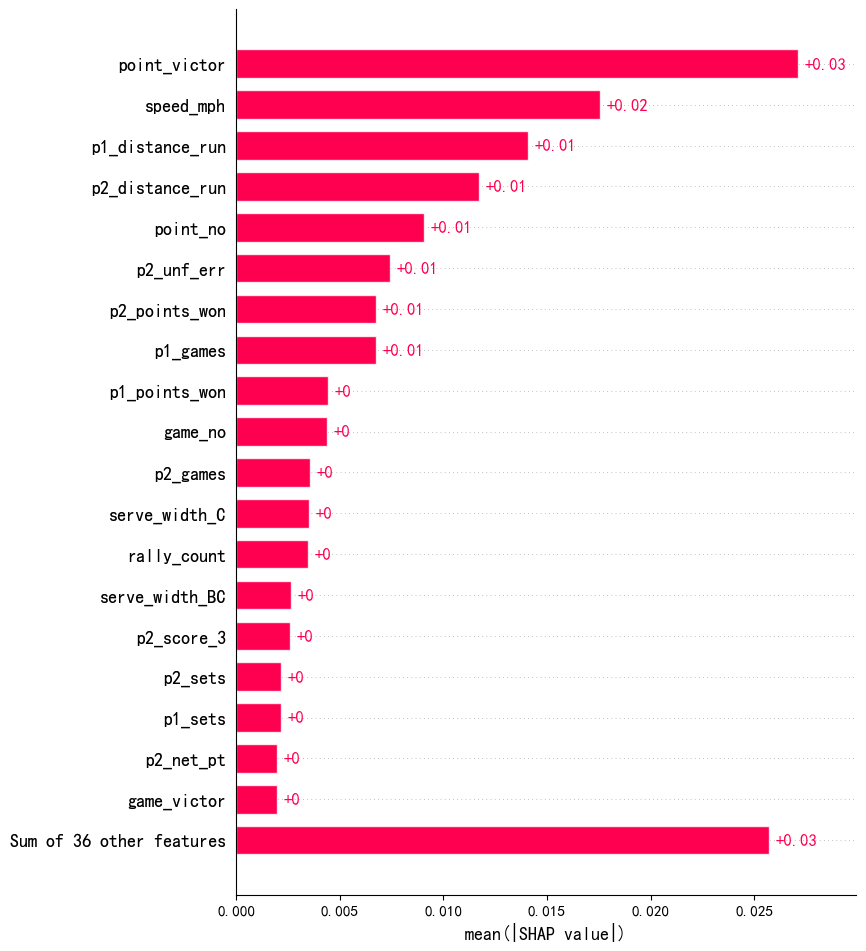

In [71]:
shap.plots.bar(explainer(X),max_display=20)

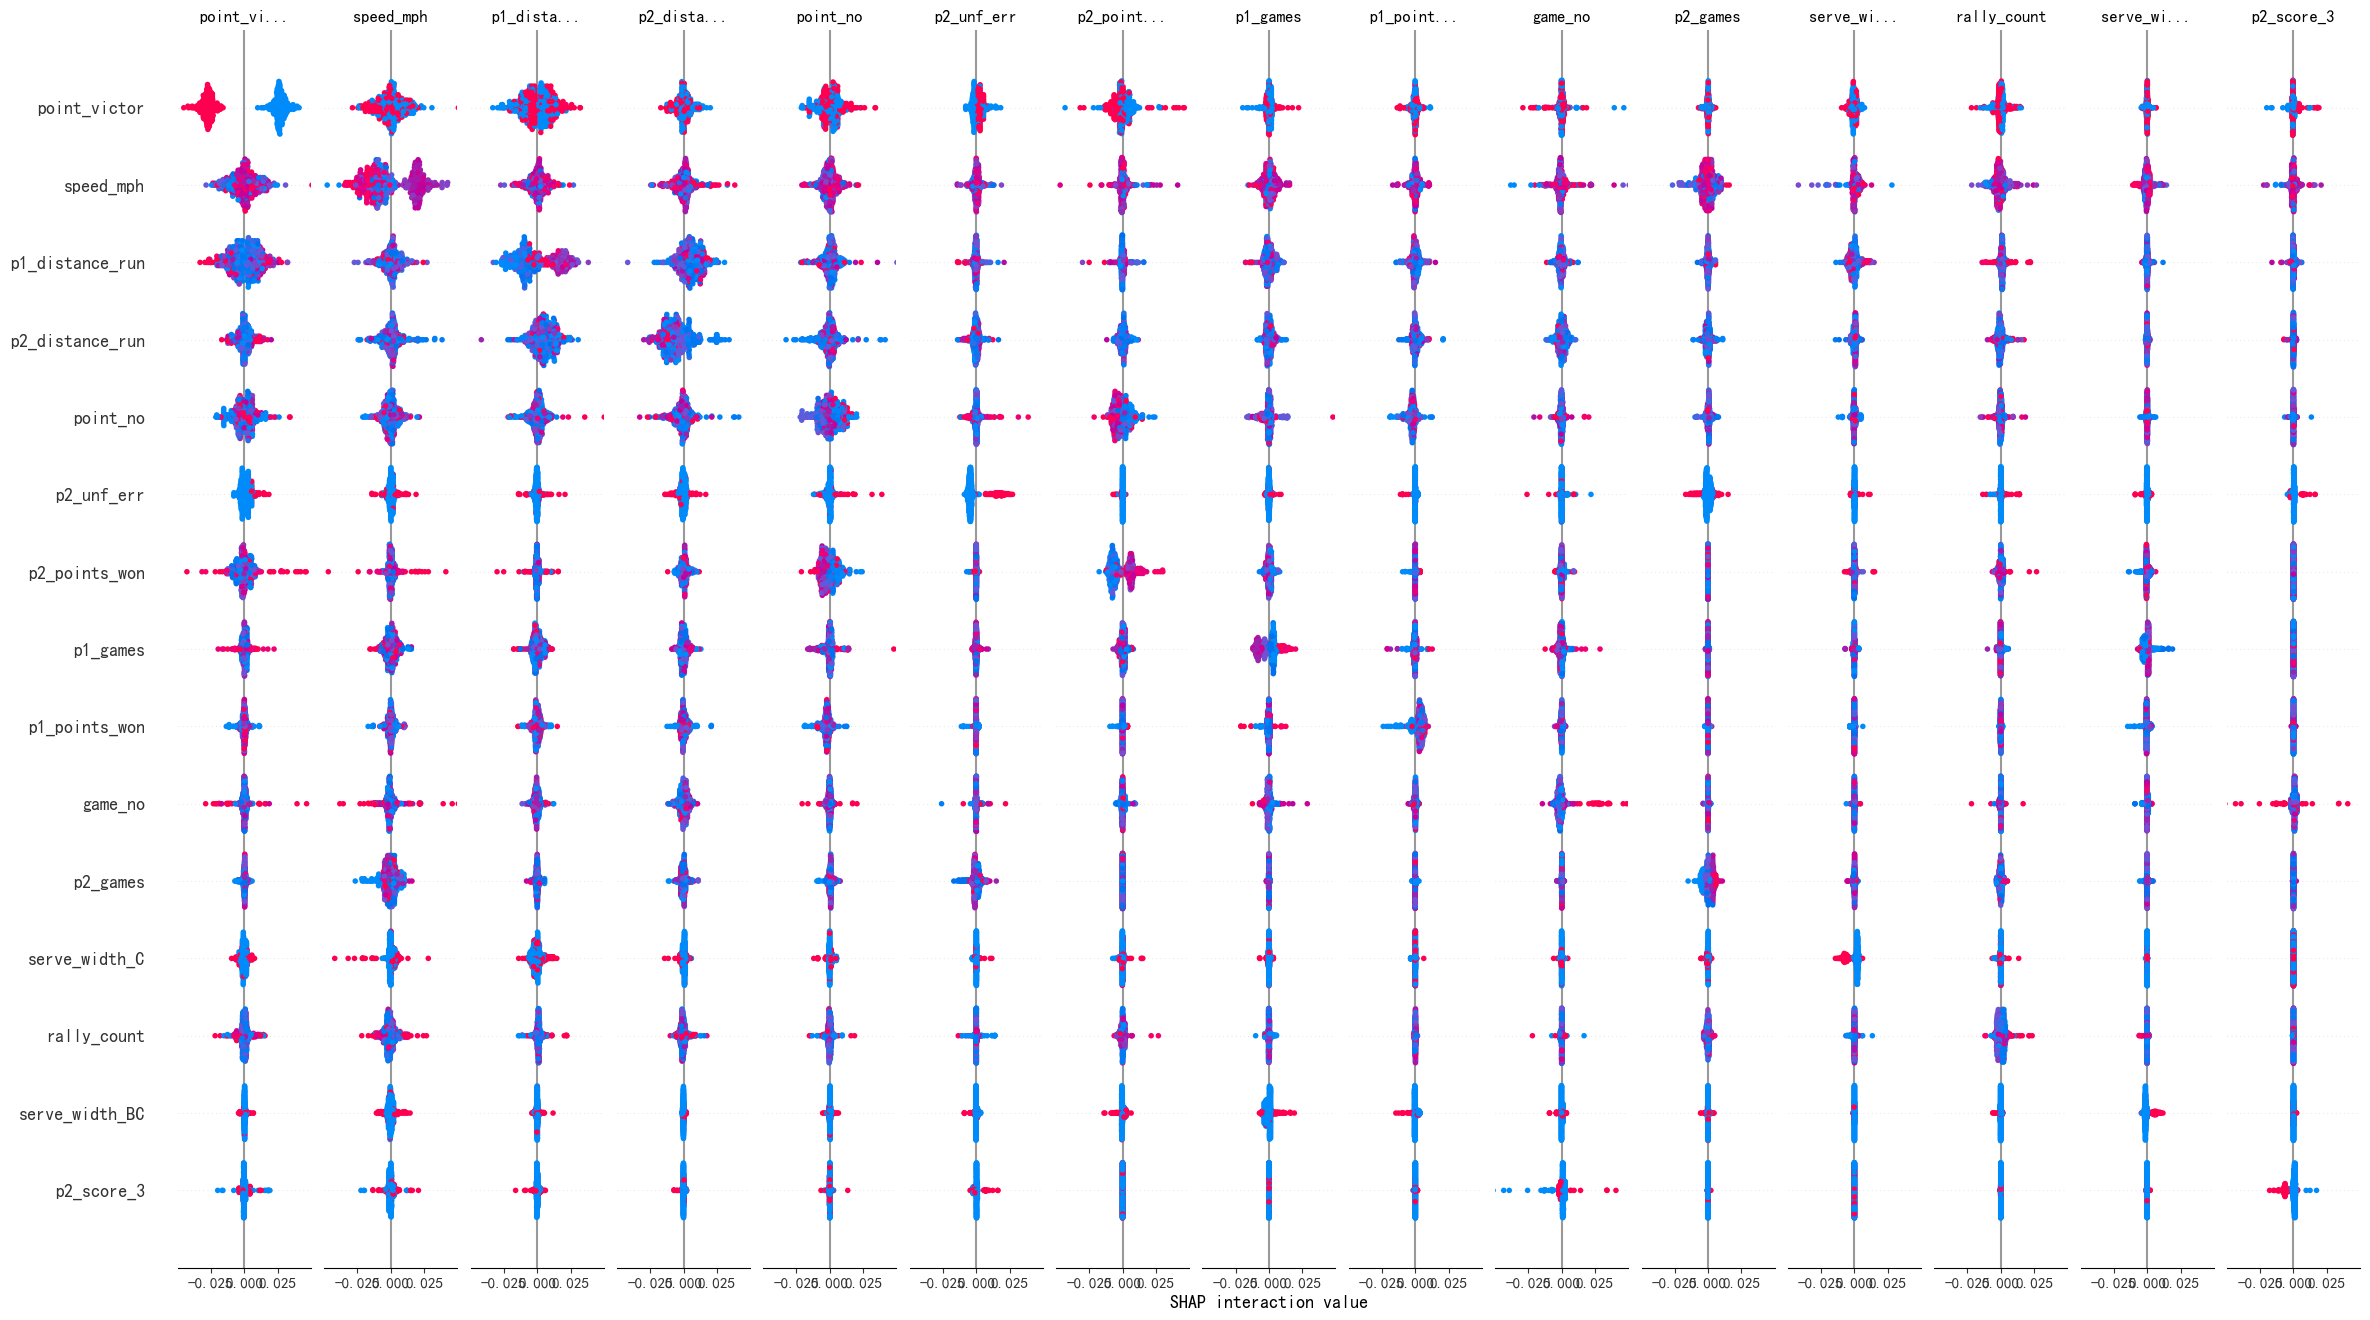

In [72]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=15)